In [1]:
import os
import numpy as np
import yaml
import torch
from omegaconf import OmegaConf

from matplotlib import pyplot as plt
from smatrix_optim.data_loader.empad_loader import EMPADLoader
from smatrix_optim.data_loader.abtem_yaml_loader import  AbTEMLoader
from smatrix_optim.data_loader.abtem_zarr_loader import AbTEMZarrLoader
from smatrix_optim.data_loader.mustem_loader import MustemLoader
from smatrix_optim.data_loader.smatrix_calc_cbed_loader import SmatrixCalcCBEDLoader
from smatrix_optim.optimisation import run_optimiser
from smatrix_optim.utility import corr_shift_cbed_torch, center_of_mass_torch, interpolate
from smatrix_optim.io_utils import *

from Pixel_class import Pixelated_STEM
from SMatrixClass import SMatrix as SMatrixNumpy
from SMatrixClassTorch import SMatrix as SMatrixTorch

import make_potential_class

In [2]:
save_dir_suffix = "" #"set_initial_true_potential"

In [3]:
path_config = "/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_35nm_long_iter.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_dose_640e.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_smaller_lr_thickness.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_onestep.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/SMatrix_foward_calc/params_optimisation_SmatrixFwd_STO_35nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_Au_20nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_Au_30nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_Pade_scale_256.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_4x4SC_fixed_th_df.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_kmax_Losscalc_1.1.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_kmax_truncation_2.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm_4x4SC_fixed_th_df.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_35nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/abTEM_1.0.6/params_optimisation_abTEM_STO_40nm.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_smatrix_GPAW_sourcesize0.6A_largelr_potential.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_smatrix_GPAW.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_smatrix_GPAW_sourcesize0.6A.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_mustem_ionic_abs_sourcesize_FWHM0.6A_largeLr_potential.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_smatrix_neutral_sourcesize_FWHM0.6A_largeLr_potential_amsgrad.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_abTEM_sourcesize_FWHM0.6A_largeLr_potential_kmaxforloss_1.1.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_abTEM_sourcesize_FWHM0.6A_largeLr_potential_LargeInitialError.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_abTEM_sourcesize_FWHM0.6A_largeLr_potential.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_abTEM_sourcesize_FWHM0.6A_largeLr_sourcesize_longiteration.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/test/params_optimisation_test_abTEM_sourcesize_FWHM0.6A.yaml"
#"/home/kousuke/abtem_env/workspace/private/STO/SMatrix_simulated_GPAW_DFT_potential/params_optimisation_smatrix_GPAW_80kV42mrad_th100A_df-50A.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_smatrix_ionic_with_neutral_abs_potential.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_mustem_ionic_abs.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_mustem_neutral_abs.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_smatrix_ionic.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_mustem_ionic_FPh.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_smatrix_GPAW.yaml"
#"/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test_abTEM.yaml"
config_optim = OmegaConf.load(path_config)

In [4]:
if config_optim['data_type'] == "empad":
    data_loader = EMPADLoader(config_optim['config_path'])
elif config_optim['data_type'] == "smatrix_calc_cbed":
    data_loader = SmatrixCalcCBEDLoader(config_optim['config_path'])
elif config_optim['data_type'] == "abtem":
    data_loader = AbTEMLoader(config_optim['config_path'])
elif config_optim['data_type'] == "mustem":
    data_loader = MustemLoader(config_optim['config_path'])
elif config_optim['data_type'] == "abtem_zarr":
    data_loader = AbTEMZarrLoader(config_optim['config_path'])
else:
    raise ValueError("Invalid data type specified in the configuration.")

In [5]:
# Load the data
data_loader.load_data()
cbed = data_loader.raw_params['data']
cbed = data_loader.binning_diff(cbed, config_optim['binning_diff'])
data_loader.raw_params['sampling_diff'][0] = data_loader.raw_params['sampling_diff'][0] * config_optim['binning_diff']
data_loader.raw_params['sampling_diff'][1] = data_loader.raw_params['sampling_diff'][1] * config_optim['binning_diff']

cbed = data_loader.centering_crop_diff_com(
    data=cbed,
    crop_size=[40,40] #[50,50] #[60, 60] #[35,35]
)

In [6]:
data_loader.raw_params['sampling_diff']

[0.08529293859761351, 0.08529293859761351]

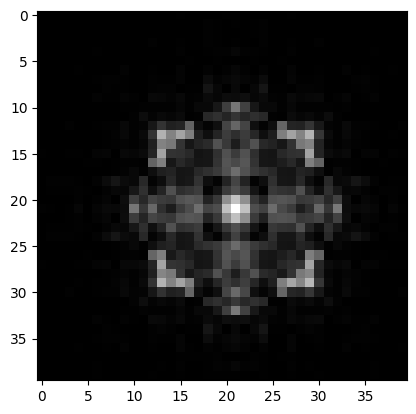

In [7]:
plt.imshow(cbed[0,0], cmap='gray')

In [8]:
tile_scan_ny, tile_scan_nx = config_optim['unitcell_tiling'] #3,3
cbed = np.tile(cbed, (tile_scan_ny, tile_scan_nx, 1, 1))

In [9]:
pixel = Pixelated_STEM(
    voltage =data_loader.raw_params['voltage'],
    aperture=data_loader.raw_params['aperture'],
)
pixel.load_parameter(
    thickness=config_optim['thickness_init'],
    defocus  =config_optim['defocus_init'],
    dry=data_loader.raw_params['sampling_scan'][0],
    drx=data_loader.raw_params['sampling_scan'][1],
    dkx=data_loader.raw_params['sampling_diff'][0], #*config_optim['binning_diff'],
    dky=data_loader.raw_params['sampling_diff'][1], #*config_optim['binning_diff'],
    rot_offset_rad=data_loader.raw_params['rot_offset_deg']*np.pi/180,
)
pixel.cbed_import(cbed)

if "sourcesize_measured" in config_optim:
    pixel.source_blur(config_optim['sourcesize_measured'], ratio_GtoL=1, axis=(0,1))
if "dose_measured" in config_optim:
    cbed_noise = np.random.poisson(pixel.cbed_data*config_optim['dose_measured'])/config_optim['dose_measured']
    pixel.cbed_import(cbed_noise)
    
pixel.cbed_import(pixel.cbed_data/np.sum(pixel.cbed_data, axis=(2,3))[:,:,np.newaxis,np.newaxis])

obf_from_measured_cbed = pixel.OBF_pixel()

4D data imported!
4D data imported!
100.0% done...

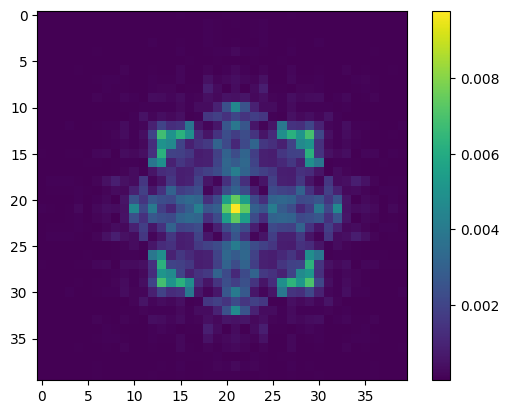

In [10]:
plt.imshow(pixel.cbed_data[0,0])
plt.colorbar()

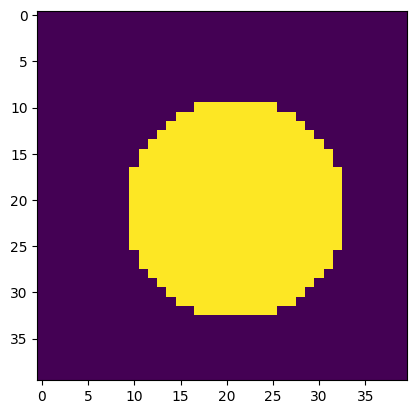

In [11]:
plt.imshow(pixel.D(pixel.kgrid[0], pixel.kgrid[1], inner=0, outer=1))

In [12]:
pixel.cbed_data.shape

(54, 54, 40, 40)

In [13]:
if "xtl_file_path" in config_optim:
    nry_iam_pot_uc = int(pixel.ry/config_optim['unitcell_tiling'][0]/config_optim['potential_grid_sampling'])
    nrx_iam_pot_uc = int(pixel.rx/config_optim['unitcell_tiling'][1]/config_optim['potential_grid_sampling'])

    nry_iam_pot_sc = nry_iam_pot_uc*config_optim['unitcell_tiling'][0]
    nrx_iam_pot_sc = nrx_iam_pot_uc*config_optim['unitcell_tiling'][1]

    iam_pot = make_potential_class.makepot(
        filepath=config_optim['xtl_file_path'],
        voltage_kV=data_loader.raw_params['voltage'],
        ngrid=[nrx_iam_pot_uc, nry_iam_pot_uc],
    )

    Ug_els_uc = iam_pot.optical_pot_Ug(absorption=False)[0]
    Ug_els_sc = np.fft.fft2(np.tile(np.fft.ifft2(Ug_els_uc), (config_optim['unitcell_tiling'][0], config_optim['unitcell_tiling'][1])))
    Ug_els_sc = Ug_els_sc/config_optim['unitcell_tiling'][0]/config_optim['unitcell_tiling'][1]

    obf_potential_grid = interpolate(
        obf_from_measured_cbed,
        nry_iam_pot_sc,
        nrx_iam_pot_sc,
    )

else:
    obf_potential_grid = interpolate(
        obf_from_measured_cbed,
        int(pixel.nry*pixel.dry/config_optim['potential_grid_sampling']),
        int(pixel.nrx*pixel.drx/config_optim['potential_grid_sampling']),
    )

Ug_from_OBF = np.fft.fft2(obf_potential_grid/pixel.wavelength/np.pi)\
                *config_optim['potential_grid_sampling']*config_optim['potential_grid_sampling']/pixel.ry/pixel.rx/config_optim.thickness_init

Crystal structure file: SrTiO3_001


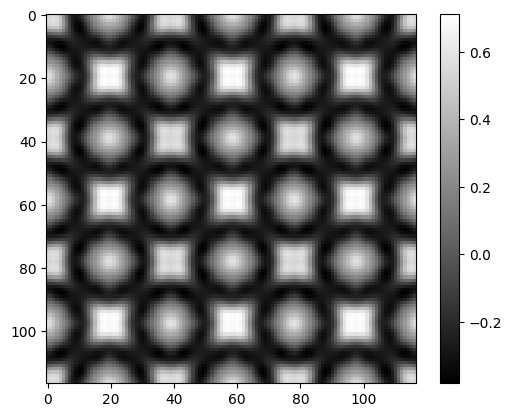

In [14]:
plt.imshow(obf_potential_grid, cmap='gray')
plt.colorbar()

number of beams:  1033


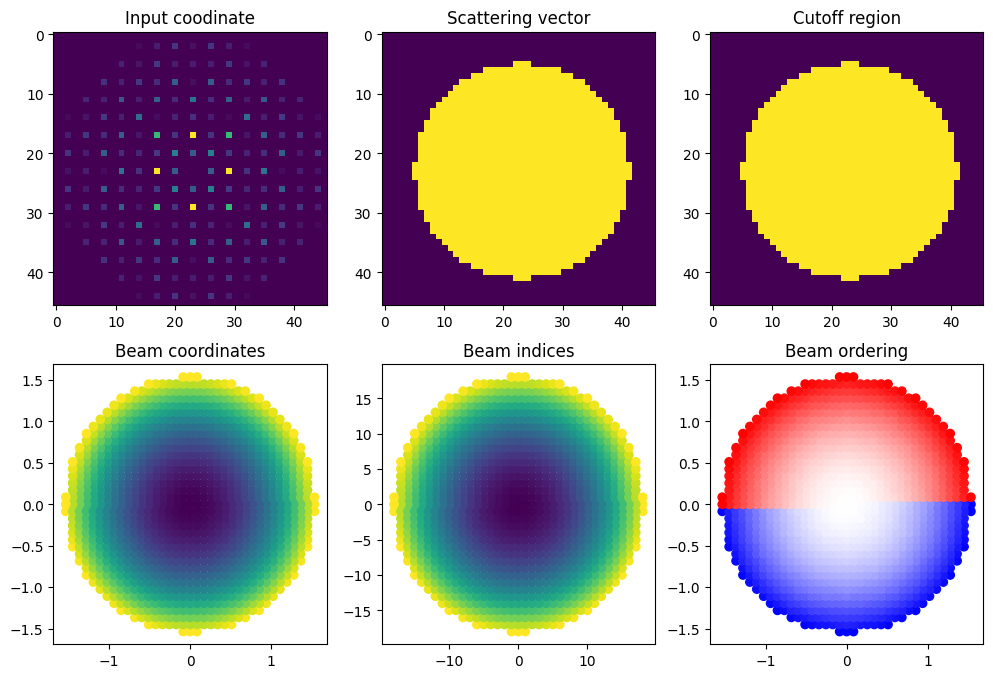

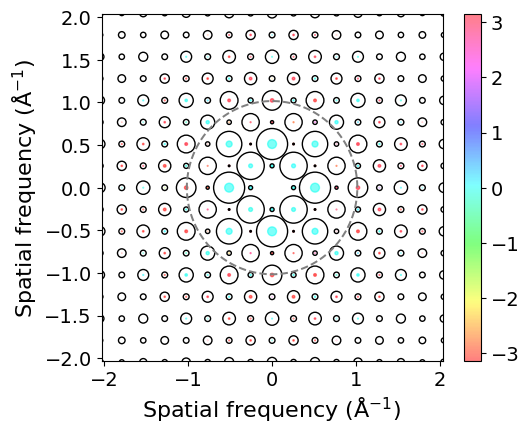

In [15]:
obf_offset_factor = 1

# set beams
smatrix_np = SMatrixNumpy(
    voltage       = pixel.voltage,
    aperture_mrad = pixel.aperture,
)
smatrix_np.make_grid(
    ry = pixel.ry,
    rx = pixel.rx,
    ny = Ug_from_OBF.shape[0],
    nx = Ug_from_OBF.shape[1],
)
smatrix_np.set_beams_from_image(image_fft=Ug_from_OBF, amp_cutoff=0e-10, show_beams=True, cutoff_k_frac=config_optim["beam_outer_angle"]*1.01)
plt.figure(figsize=(5.5,4.5))
smatrix_np.Ug_circle_plot(Ug_from_OBF*obf_offset_factor, Ug_els_sc, display_factor_kmax=2, circle_size_factor=500, size_cutoff=1e-5)

In [16]:
# gpu or cpu for optimization
if torch.cuda.is_available():
    device  = torch.device('cuda')
    use_gpu = True
else:
    device = torch.device('cpu')

if config_optim['use_cpu']:
    device  = torch.device('cpu')
    use_gpu = False

In [17]:
smatrix_torch = SMatrixTorch(
    voltage       = pixel.voltage,
    aperture_mrad = pixel.aperture,
    gpu_use       = use_gpu
)
smatrix_torch.make_grid(
    ry = pixel.ry,
    rx = pixel.rx,
    ny = Ug_from_OBF.shape[0],
    nx = Ug_from_OBF.shape[1],
)
smatrix_torch.import_beams(
    beam_coordinates=smatrix_np.beam_coordinates,
    beam_indices=smatrix_np.beam_indices
)

In [18]:
thickness_init      = torch.tensor(config_optim['thickness_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_thickness'])
defocus_init        = torch.tensor(config_optim['defocus_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_defocus'])
sourcesize_init     = torch.tensor(config_optim['sourcesize_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_sourcesize'])
tilt_rad_init       = torch.tensor(config_optim['tilt_rad_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_tilt'])
coma_init           = torch.tensor(config_optim['coma_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_coma'])
twofold_stig_init   = torch.tensor(config_optim['twofold_stig_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_twofold_stig'])
threefold_stig_init = torch.tensor(config_optim['threefold_stig_init'], device=device, dtype=torch.float32).requires_grad_(config_optim['optim_threefold_stig'])

In [19]:
scan_y = torch.arange(pixel.nry, device=device, dtype=torch.float32).view(pixel.nry, 1).expand(pixel.nry, pixel.nrx) / pixel.nry * pixel.ry
scan_x = torch.arange(pixel.nrx, device=device, dtype=torch.float32).view(1, pixel.nrx).expand(pixel.nry, pixel.nrx) / pixel.nrx * pixel.rx

probe_position_init = torch.stack([scan_y, scan_x], dim=-1).to(device).requires_grad_(config_optim['optim_probe_position'])

In [20]:
probe_position_original = torch.stack([scan_y, scan_x], dim=-1).to(device).clone().detach()

In [21]:
initial_params = {
    'potential_Ug': Ug_from_OBF, #Ug_els_sc, #Ug_from_OBF * obf_offset_factor,
    'thickness': thickness_init,
    'defocus': defocus_init,
    'source_fwhm': sourcesize_init,
    'tilt_rad': tilt_rad_init,
    'coma': coma_init,
    'twofold_stig': twofold_stig_init,
    'threefold_stig': threefold_stig_init,
    'probe_position': probe_position_init,
}

In [22]:
data_loader.raw_params['sampling_diff']

[0.08529293859761351, 0.08529293859761351]

In [23]:
result_optim = run_optimiser(      
    smatrix_torch=smatrix_torch,
    smatrix_np=smatrix_np,
    measured_data=torch.tensor(pixel.cbed_data, device=device, dtype=torch.float32),
    initial_params=initial_params,
    data_loader_params=data_loader.raw_params,
    config=config_optim,
    device=device
)

35 35
torch.Size([54, 54, 35, 35])
Starting optimization loop...
Iteration complete0 of kcutoff group 2/2: Loss = 3.8907 - 100.0% complete


In [24]:
save_dir = os.path.dirname(path_config) + "/" + os.path.basename(path_config).replace(".yaml", "") + save_dir_suffix #os.path.basename(path_config).split(".")[0]
os.makedirs(save_dir, exist_ok=True)
save_dir+= "/"
#print("save_dir", save_dir)

In [25]:
obf_image = np.fft.ifft2(result_optim['obf_initial']).real
pot_els_optimised = np.fft.ifft2(result_optim['potential_els']).real
pot_abs_optimised = np.fft.ifft2(result_optim['potential_abs']).real

save_image(obf_image, save_dir + "obf_image.tiff")
save_image(pot_els_optimised, save_dir + "potential_els_optimised.tiff")
save_image(pot_abs_optimised, save_dir + "potential_abs_optimised.tiff")

#plt.imshow(pot_abs_optimised)

In [26]:
save_scan_position_diff(
    scan_position_init=probe_position_original.cpu().numpy(),
    scan_position_optim=result_optim['optimised_probe_position'],
    save_dir=save_dir,  
)

save_cbed_diff(
    cbed_1=result_optim['estimated_cbed'],
    cbed_2=result_optim['measured_cbed'],
    save_dir=save_dir,
)

In [27]:
plot_params_history_main(optim_results=result_optim, save_dir=save_dir)
plot_params_history_aberrations(optim_results=result_optim, save_dir=save_dir)

In [28]:
potential_circle_plot(
    smatrix_np=smatrix_np,
    optimised_Ug=result_optim['potential_els'],
    reference_Ug=Ug_els_sc,
    save_dir=save_dir,
)

In [29]:
save_optimised_potential_image(
    Ug_optimised=result_optim['potential_els'],
    Ug_reference=Ug_els_sc,
    Ug_obf=Ug_from_OBF,
    save_dir=save_dir,
)

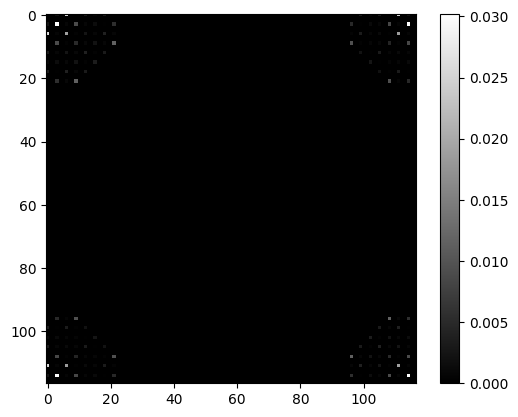

In [30]:
plt.imshow(np.abs(result_optim['potential_els']), cmap='gray')
plt.colorbar()

In [31]:
os.makedirs(save_dir+'params_history', exist_ok=True)
np.save(save_dir+'params_history/loss_history.npy', result_optim['loss_history'])
np.save(save_dir+'params_history/thickness_history.npy', result_optim['thickness_history'])
np.save(save_dir+'params_history/defocus_history.npy', result_optim['defocus_history'])
np.save(save_dir+'params_history/source_size_history.npy', result_optim['source_size_history'])

np.save(save_dir+'params_history/tilt_history_y.npy', result_optim['tilt_history_y'])
np.save(save_dir+'params_history/tilt_history_x.npy', result_optim['tilt_history_x'])
np.save(save_dir+'params_history/coma_history_y.npy', result_optim['coma_history_y'])
np.save(save_dir+'params_history/coma_history_x.npy', result_optim['coma_history_x'])
np.save(save_dir+'params_history/twofold_stig_history_y.npy', result_optim['twofold_stig_history_y'])
np.save(save_dir+'params_history/twofold_stig_history_x.npy', result_optim['twofold_stig_history_x'])
np.save(save_dir+'params_history/threefold_stig_history_y.npy', result_optim['threefold_stig_history_y'])
np.save(save_dir+'params_history/threefold_stig_history_x.npy', result_optim['threefold_stig_history_x'])
np.save(save_dir+'params_history/probe_position.npy', result_optim['optimised_probe_position'])